In [1]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

24/07/02 14:37:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# create a spark context
sc = spark.sparkContext

In [4]:
data = fetch_kddcup99(return_X_y = True, percent10 = True) # default percent10=True

In [5]:
## ADD TABLES WITH MATPLOTLIB

# DESCRIBE THE DATA SET

In [6]:
print("The number of samples is ", data[0].shape[0])
print("The dimensionality is ", data[0].shape[1])

The number of samples is  494021
The dimensionality is  41


Classes: 23
Samples total: 4898431
Dimensionality: 41
Features: discrete (int) or continuous (float)

The first containing a 2D array of shape (n_samples, n_features) with each row representing one sample and each column representing the features


The first 4 elements of the data set (letters, what are them)
Duration: The length (in seconds) of the connection.
Protocol Type: The type of protocol used, such as TCP, UDP, or ICMP.
Service: The network service on the destination, such as HTTP, FTP, or SMTP.
Flag: The status flag of the connection, such as SF (successful connection), REJ (connection rejected), etc.

In [7]:
# collect samples and features (target)
x = data[0]
y = data[1] 

In [8]:
nSlice = None
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i]}) for i in range(data[0].shape[0])], numSlices = nSlice)

In [9]:
Rdd.getNumPartitions() # check partitions

8

Check and delete the symbolic variables in the dataset

In [10]:
typeElement = Rdd.map(lambda datum: datum[1]["x"])\
                 .map(lambda x: [set([type(x[i])]) for i in range(len(x))])\
                 .reduce(lambda a, b: [a[i].union(b[i]) for i in range(len(a))])

24/07/02 14:37:28 WARN TaskSetManager: Stage 0 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.


In [11]:
print("The types of the dimensionalities are:")
typeElement

The types of the dimensionalities are:


[{int},
 {bytes},
 {bytes},
 {bytes},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {int},
 {int},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float}]

In [12]:
numberColumns = len([i for i in typeElement if i != set([bytes])])
print("The number of columns (dimensionality) after filtering the bytes is", numberColumns)

The number of columns (dimensionality) after filtering the bytes is 38


In [13]:
%%time
uniquesParallel = []
for i in range(41):
    s = Rdd.map(lambda datum: datum[1]["x"])\
        .map(lambda x: x[i])\
        .distinct()\
        .count()
    uniquesParallel.append(s)

24/07/02 14:37:31 WARN TaskSetManager: Stage 1 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/07/02 14:37:33 WARN TaskSetManager: Stage 3 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/07/02 14:37:35 WARN TaskSetManager: Stage 5 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/07/02 14:37:36 WARN TaskSetManager: Stage 7 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/07/02 14:37:37 WARN TaskSetManager: Stage 9 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/07/02 14:37:40 WARN TaskSetManager: Stage 11 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/07/02 14:37:41 WARN TaskSetManager: Stage 13 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.
24/0

CPU times: user 333 ms, sys: 99.4 ms, total: 433 ms
Wall time: 50.8 s


In [15]:
print("The number of uniques is", uniquesParallel)

The number of uniques is [2495, 3, 66, 11, 3300, 10725, 2, 3, 4, 22, 6, 2, 23, 2, 3, 20, 18, 3, 7, 1, 1, 2, 490, 470, 92, 51, 77, 51, 99, 78, 64, 256, 256, 101, 101, 101, 65, 100, 72, 101, 101]


In [16]:
%%time
uniques = []
for i in range (x.shape[1]):
    k = (len(np.unique(x[:, i])))
    uniques.append(k)
print("The uniques are:", uniques)

The uniques are: [2495, 3, 66, 11, 3300, 10725, 2, 3, 4, 22, 6, 2, 23, 2, 3, 20, 18, 3, 7, 1, 1, 2, 490, 470, 92, 51, 77, 51, 99, 78, 64, 256, 256, 101, 101, 101, 65, 100, 72, 101, 101]
CPU times: user 10.6 s, sys: 8.14 ms, total: 10.7 s
Wall time: 10.7 s


It takes 4 times for to do it in parallel (explain what is better to use)

In [17]:
# why running it a second time takes way more time?

In [18]:
%%time
kTrue = Rdd.map(lambda datum: datum[1]["y"])\
        .distinct()\
        .count()

24/07/02 14:40:08 WARN TaskSetManager: Stage 83 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 4.42 ms, sys: 8.04 ms, total: 12.5 ms
Wall time: 979 ms


In [19]:
print("The true number of the classes is", kTrue)

The true number of the classes is 23


In [35]:
%%time
uniquesParallely = Rdd.map(lambda datum: datum[1]["y"])\
        .countByValue()

print("The y things are:", uniquesParallely)

24/07/02 14:46:45 WARN TaskSetManager: Stage 87 contains a task of very large size (15220 KiB). The maximum recommended task size is 1000 KiB.


The y things are: defaultdict(<class 'int'>, {b'normal.': 97278, b'buffer_overflow.': 30, b'loadmodule.': 9, b'perl.': 3, b'neptune.': 107201, b'smurf.': 280790, b'guess_passwd.': 53, b'pod.': 264, b'teardrop.': 979, b'portsweep.': 1040, b'ipsweep.': 1247, b'land.': 21, b'ftp_write.': 8, b'back.': 2203, b'imap.': 12, b'satan.': 1589, b'phf.': 4, b'nmap.': 231, b'multihop.': 7, b'warezmaster.': 20, b'warezclient.': 1020, b'spy.': 2, b'rootkit.': 10})
CPU times: user 9.5 ms, sys: 3.83 ms, total: 13.3 ms
Wall time: 846 ms


In [72]:
yUnique = [a.decode('utf-8') for a in uniquesParallely.keys()]
xUnique = list(uniquesParallely.values())
attributes = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]


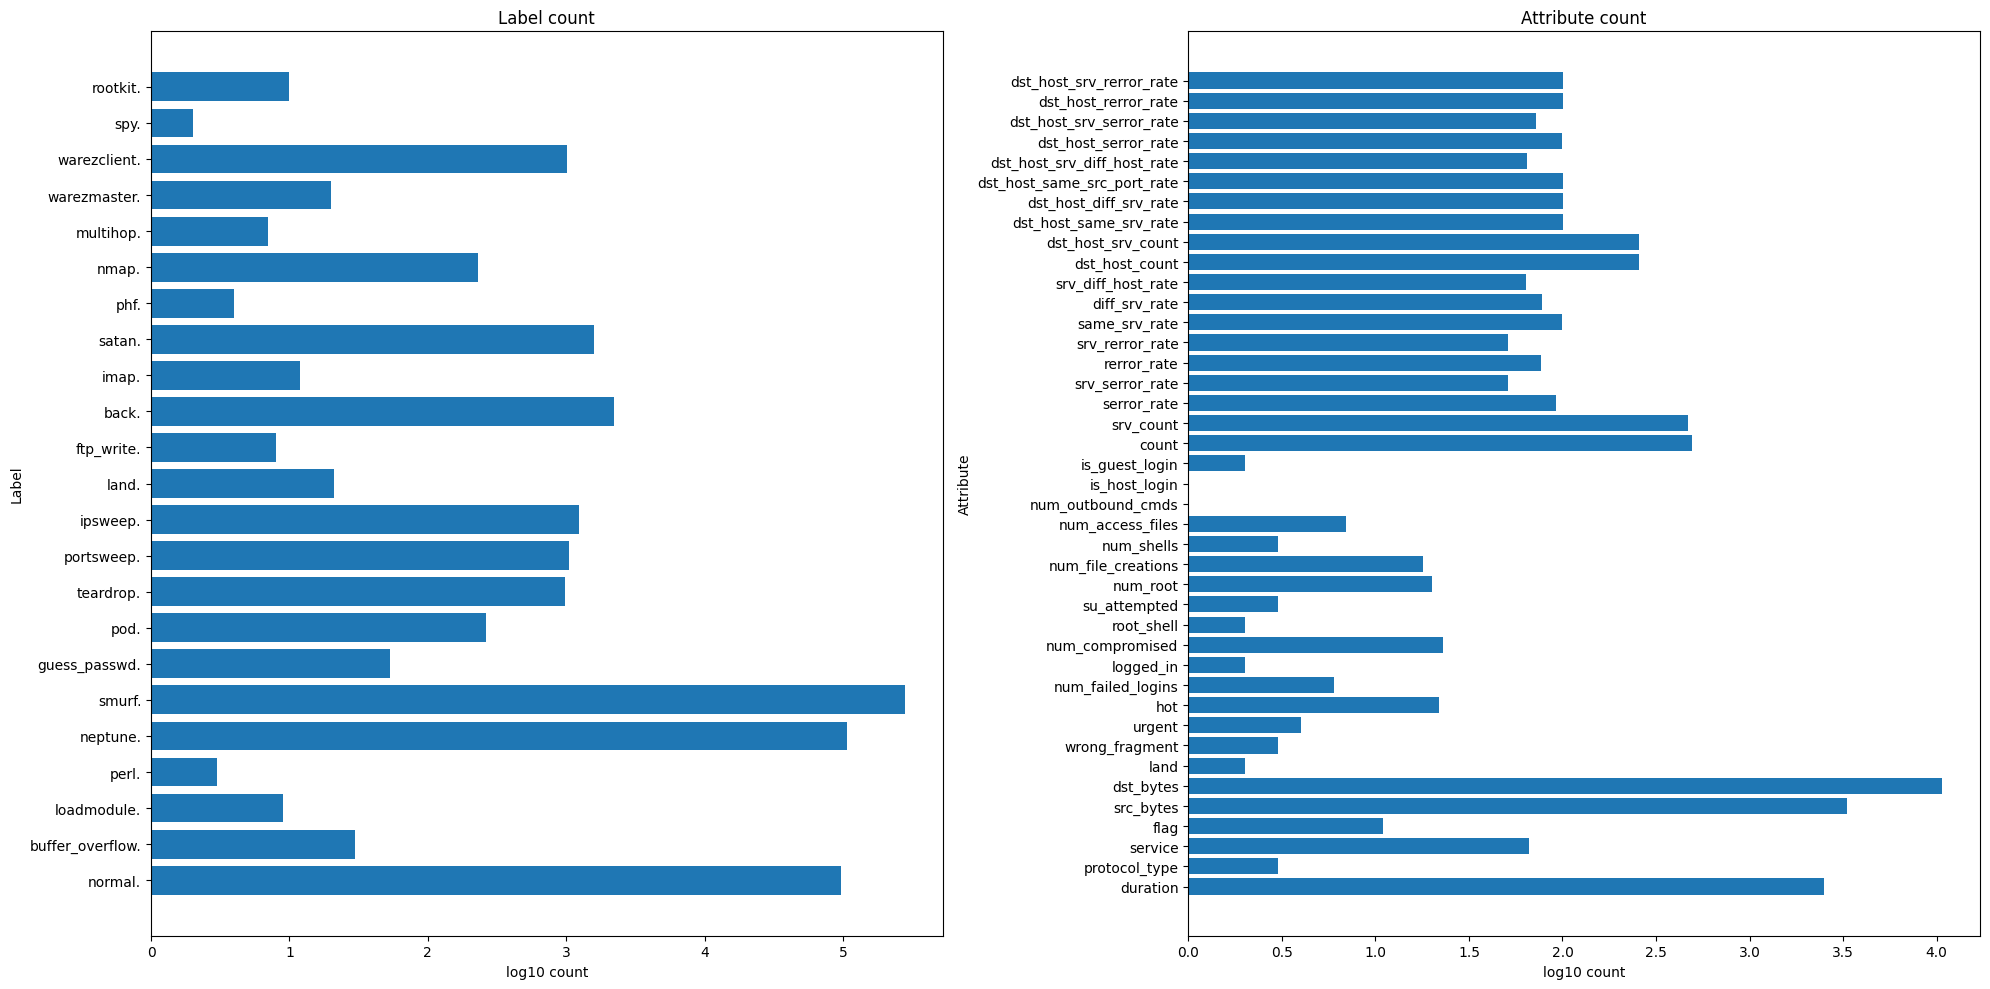

In [81]:
# add log 10 the ax and npt the count
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].barh(yUnique, np.log10(xUnique))
ax[0].set_xlabel("log10 count")
ax[0].set_ylabel("Label")
ax[0].set_title("Label count")
ax[1].barh(attributes, np.log10(uniquesParallel))
ax[1].set_xlabel("log10 count")
ax[1].set_ylabel("Attribute")
ax[1].set_title("Attribute count")
fig.tight_layout()

In [82]:
def deleteBytes(datum):
    x = datum[1]["x"]
    mask = [type(i) != bytes for i in x]
    datum[1]["x"] = np.asarray(x[mask])
    print(x)
    print(mask)
    return datum

In [83]:
Rdd = Rdd.map(deleteBytes)\
         .persist()

In [ ]:
def minmaxRescale(datum, minS, maxS):
    mask = (minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"]})   



In [ ]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

print(maxS.shape)
print((minS < maxS).astype(bool))

In [ ]:
a,b=np.array([1,3,5]), np.array([2,1,5])
print(np.maximum(a,b))

In [ ]:
print(*zip(minS, maxS))
print((minS < maxS).astype(bool).shape)

In [ ]:
#### fix ####
# %%time
# results = Rdd.map(lambda datum: datum["x"])\
#               .reduce(lambda a, b: (np.maximum(a[0], b[0]), np.minimum(a[1], b[1]))

In [ ]:
Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))
print(Rdd.takeSample(False, 3)[0][1]['x'].shape)


In [ ]:
local_datum=Rdd.takeSample(False, 3)[0]

In [ ]:
def selectCluster(datum, C):
    """
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    clusterId = np.argmin(distances)
    return (clusterId, datum[1])

In [ ]:
'''
C_init=naiveInitFromSpace(14, len(local_datum[1]['x']))
print(C_init.shape)
'''

In [ ]:
'''
C_init=[el for el in C_init]
print(selectCluster(local_datum, C_init))
'''

In [ ]:
#update centroids as 'centers of mass' of clusters
def updateCentroids(Rdd):
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


In [ ]:
#lets assume entry of xy dictionary to be distance opf point from its centroid
# ADD IF NOT TIME CONSUMING d ENTRY IN XY DICTIONARY FOR CONSISTENCY

#update the Rdd with square distances from centroids, given Rdd with centroids already updated 
def updateDistances(Rdd, C):
    def datumUpdate(datum, C):
        datum[1]['d2']=np.sum((datum[1]['x']-C[datum[0]])**2)
        return datum
    Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd
#calculate global cost of X,C from an Rdd with distances from centroids already updated
def cost(Rdd):
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
       .reduce(lambda a,b: a+b)
    return my_cost 

In [ ]:
def kMeans(Rdd, C_init, maxIterations):
    C=C_init
    for t in range(maxIterations):
        Rdd = Rdd.map(lambda datum: selectCluster(datum, C))
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(Rdd)
    return C

Different initialization functions

In [ ]:
def naiveInitFromSet(Rdd, k):
    #uniform sampling of k points from Rdd
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])
    return C_init
def naiveInitFromSpace(k, dim):
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    C_init=np.random.uniform(size=(k,dim))
    return C_init

In [ ]:
'''
1: C ← sample a point uniformly at random from X
2: ψ ← φX (C)
3: for O(log ψ) times do
4:
C 0 ← sample each point x ∈ X independently with
2
(x,C)
probability px = `·d
φX (C)
0
5:
C ←C∪C
6: end for
7: For x ∈ C, set wx to be the number of points in X closer
to x than any other point in C
8: Recluster the weighted points in C into k clusters
'''
def parallelInit(Rdd, k, l):
    C=naiveInitFromSet(Rdd, 1)
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C)
    my_cost=cost(Rdd)
    n_iterations=int(log(my_cost))
    for _ in range(n_iterations):
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        C=np.vstack((C, C_prime))
        Rdd=Rdd.map(lambda datum : (0, datum[1]))
        Rdd=updateDistances(Rdd, C)
        my_cost=cost(Rdd)
    #erase centroids sampled more than once 
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    wx=list(zip(*wx))
    weights=np.zeros(len(C))
    weights[[wx[0]]]=[wx[1]]

In [ ]:
'''
1: C ← sample a point uniformly at random from X
2: while |C| < k do
2
3:
Sample x ∈ X with probability dφX(x,C)
(C)
4:
C ← C ∪ {x}
5: end while
'''


def localPlusPlusInit(points, k):
    C=#sample from array di punti ecc...
#TODO: implementare kmeans++locale
#implementare lloyds locale
#inserirlo in parallelInit
#Inventare test


In [ ]:
def LocalLloyds(dataset, k, weights=None): 
    #completare

In [ ]:
arr=np.zeros(5)
print(arr)
tuplas=[(3,2),(4,1),(2,12)]
untuplas=list(zip(*tuplas))
print(untuplas)
arr[[untuplas[0]]]=[untuplas[1]]
print(arr)

In [ ]:
print(naiveInitFromSet(Rdd, 14).shape)
#print(Rdd.takeSample(False, 3)[0][1]['x'])

In [ ]:
%%time
print(kMeans(Rdd, naiveInitFromSet(Rdd, 2), 10))

In [ ]:
a=np.array([[1],[2],[3]])
b= np.array([[4],[5],[6]])
print(a*b)